
# Project 10, Machine Learning

Write a code based on numpy to solve either the classification or regression problem from the open ML datasets.
- classification
- regression

By choosing one of the following methods:
- Gaussian Process


In [35]:
#imports
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from pandas import read_csv
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#Plotgpfunc. #https://github.com/sassoftware/sas-viya-machine-learning/blob/master/gaussian_process_models/gaussian_processes_util.py
#Plot_GP that would come with 
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    plt.figure(figsize=(20,10))
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)

### Gaussian Process:

###### Gaussian Process

Gaussian processes are distributions over  functions. Defined by: Mean $\mu$ and Covariance function. Think Uncertainty/probability functions/clouds.  

$f(x) ='  GP(\mu,K(x,x'))$

For regression we use the Gaussian process to find probability distributions of functions we get the prior func. for use in Bayesian methods to get a GP posterior, Bayes rule: 
$p(f|D) = \frac{p(f)p(D|f)}{p(D)}$	

**Goal**: Make predictions from noisy data

Keep in mind. 
- Multivariate Gaussians capture a finite* number of distribution
- Gaussian processes having a mean/covariance that are defined by functions themselves. Functions can have an infinite input domain, thus GPs may be used for infinite dimensions.


***
- **Mean vector matrix** $\mu = m(X)$:
Describe the expected value of the distribution

*Typically $\mu$ is assumed to equal 0, "Centering the data" for simplicity I will assume this as well. If $\mu$ != 0 add it back into the function after prediction.*    
***
- **Covariance matrix** $\Sigma = K (X,X)$: models the variance along each dimension and determines how variables are correlated. 
    - Hyperparameters - The parameters that are customizable to solve the problem in question: Choosing the covariance and hyperparameters to match is called model selection
    - Further reading on optimizing hyperparameters or choosing kernels can be found: 
    
    Hyperparameters: https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-51.pdf
    
    Kernels: https://arxiv.org/abs/1302.4922
    
    
***

**Marginalization and Conditioning:** 
- Marginalization: Using a multiple Gaussian distributions we can gain a subset input. Limiting the random variable Y with a resulting X.
    - Marginal likelihood - Since GP is a gradient based optimization algorithm its possible to obtain the "hyperparameters" that maximize the marginal likelihood of a GP
call this optimization procedure training the GP
- Conditioning: Describe the probability of a random variable in relation to another. This gives way to use a Bayesian inference to get predictions based on the observed data. 




https://distill.pub/2019/visual-exploration-gaussian-processes/

###### Kernel/Covarience Fucntion

Bread and butter of a Gaussian process 

Describes corrlations between different points in the process

$K(x,x') = \epsilon[ f(x) f(x')]$

Positive definite - symmetric/invertible matrix 

**Exponential Covariance (SE):**
Smooth/stationary sample function
$$K(x,x') = \sigma^2 e[- 0.5(x-x'/\lambda)^2]$$






https://peterroelants.github.io/posts/gaussian-process-kernels/

In [42]:
def kernel(X1, X2, l=1.0, sig=1.0):
    """
    X1 = x;X2 = x'
    l = \lambda,  Lengthscale
    sig = \sigma, Amplitude 
    """
    sqdist= np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return (sig**2 * np.exp(-1/2*((sqdist/l)**2)))

###### Prior Distribution

Random or "arbitrary" initial assumptions;

During training this becomes updated with posterior distributions from the previous epoch.

Finite number of points

Mean and covariance of the prior are run through Kernel. 

<ipython-input-37-aa1be39793d6>:12: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu.ravel(), cov, 5)


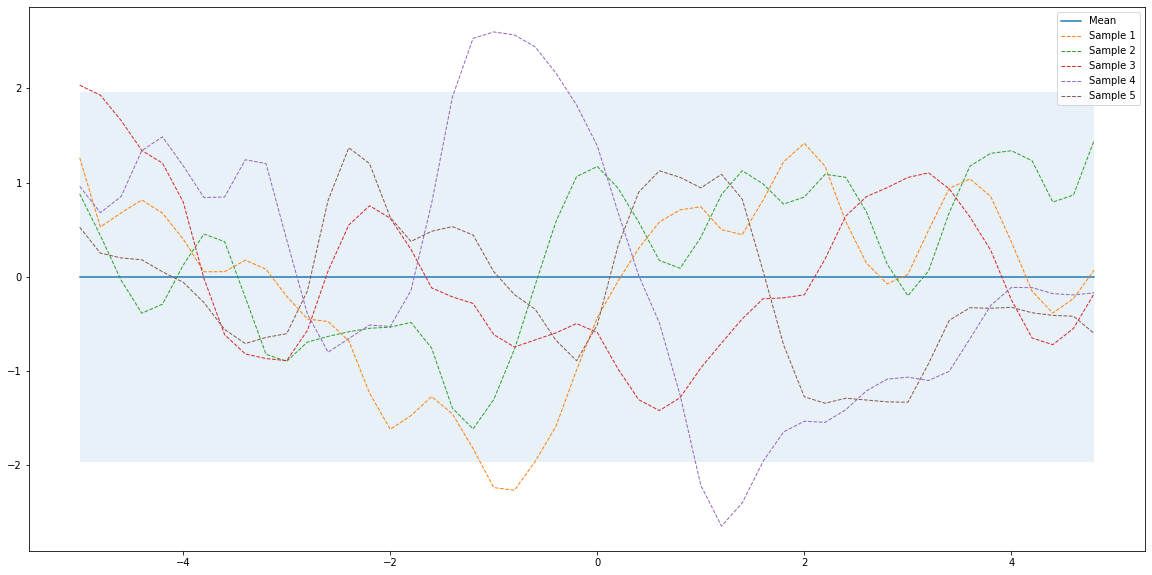

In [37]:
#from gaussian_processes_util import plot_gp;see imports.

#Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)
#print(X)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 5)

#print(mu)
#print(cov)
#print(samples)
# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)


###### Posterior Distribution/Predictions


Predictions made from observed data. 
From Bayesian inference:The Posterior is Proportional to the prior * the likelihood. 

Initial GP Prior:  $p(f|Di) =' GP(\mu = 0, K)$

Posterior:         $p(f|x,y,Di) =' GP({\mu_p}, K_p)$

Prediction distribution formula in code

In [38]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    #formula for prediction from this kernel
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

<ipython-input-39-bb181e37770a>:12: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)


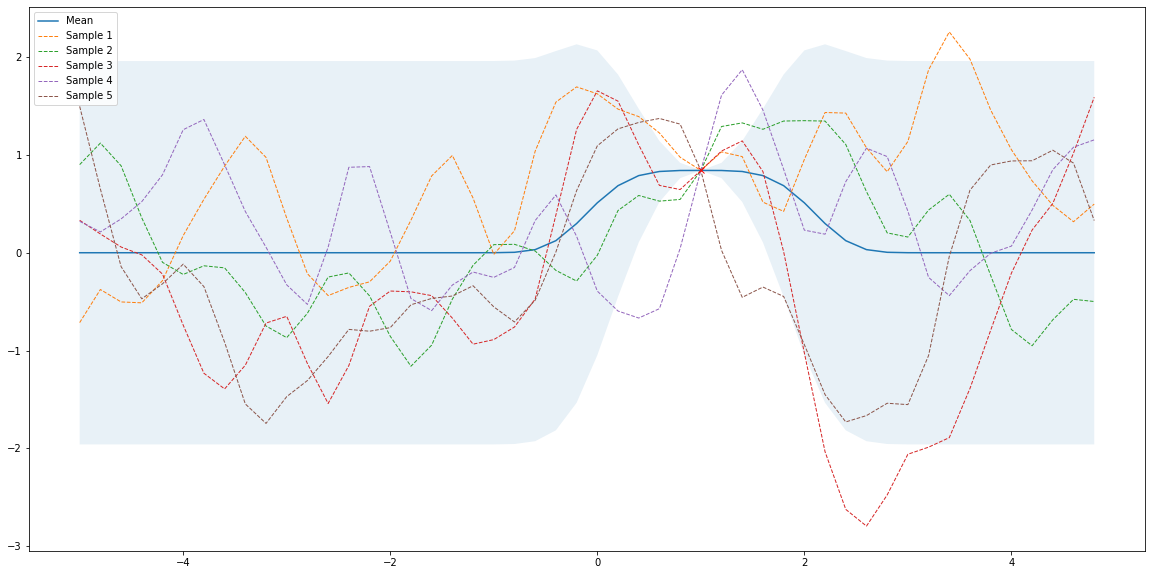

In [39]:
# Noise free training data
# Assumed perfect confidence in observed data points

X_train = np.array([1]).reshape(-1, 1)
#X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)

Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

<ipython-input-40-d9c752022921>:10: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
<ipython-input-35-b255a82ea57f>:24: RuntimeWarning: invalid value encountered in sqrt
  uncertainty = 1.96 * np.sqrt(np.diag(cov))


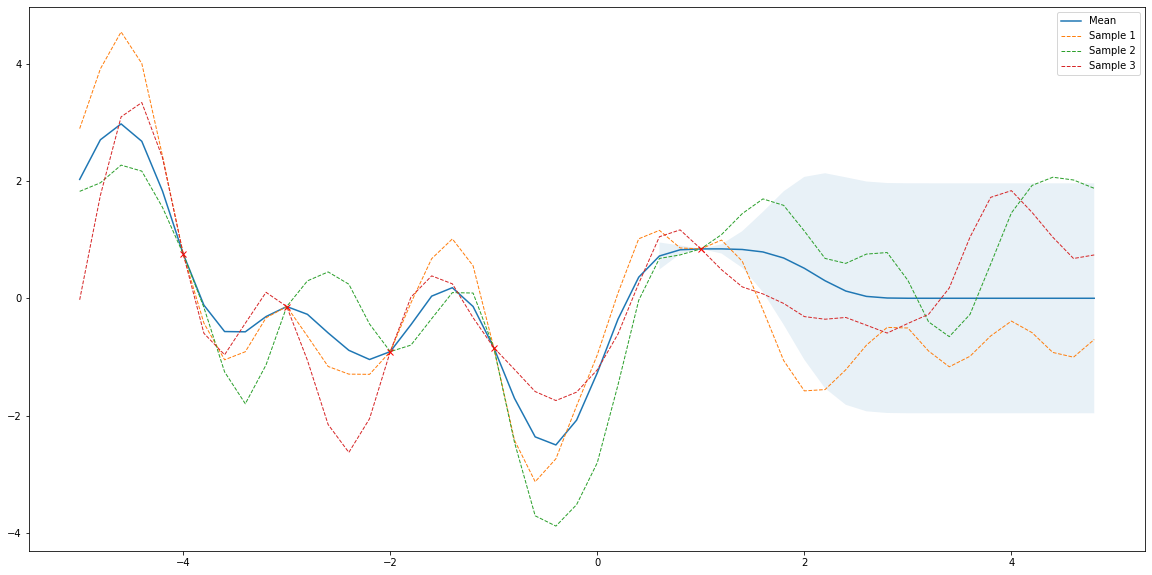

In [40]:
# Noise free training data
# Assumed perfect confidence in observed data points

X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

<ipython-input-41-0ace2f998cb9>:12: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 4)
<ipython-input-35-b255a82ea57f>:24: RuntimeWarning: invalid value encountered in sqrt
  uncertainty = 1.96 * np.sqrt(np.diag(cov))


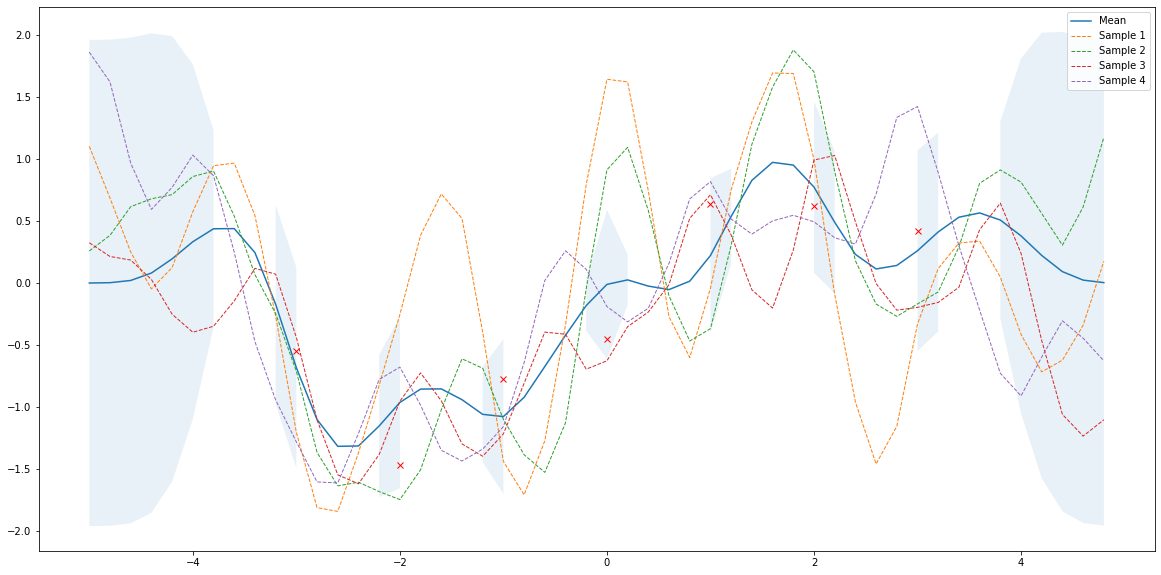

In [41]:
#adding noise
# Realistically we have noise in data. 
noise = 0.5

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape) #only change 

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 4)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

***

In [21]:
#Regression with sklearn: wine quality 
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF,RationalQuadratic
#X, y = make_friedman2(n_samples=500, noise=0, random_state=0)

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
dataset = read_csv(url, sep=';')

# shape
#print(dataset.shape)

#print(dataset.groupby('quality').size())
# Split-out validation dataset
array = dataset.values
X = array[:,0:11]
y = array[:,11]

#kernel = DotProduct() [not returning a positive definite matrix.]
##kernel = WhiteKernel(): [-48.736840968254135; (array([0., 0.]), array([5.69354988, 5.69354988]));4.75 ms ± 120 µs per loop]
kernel = DotProduct() + WhiteKernel()

gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X, y)
print(gpr.score(X, y))
print(gpr.predict(X[:2,:], return_std=True))

%timeit gpr.score(X,y)

0.3600375688294316
(array([5.04240933, 5.13593949]), array([0.64917796, 0.64985582]))
47.9 ms ± 5.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


E:\zthel\Documents\ANACONDA\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
E:\zthel\Documents\ANACONDA\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


LR: 0.573930 (0.043433)
NB: 0.536362 (0.036234)


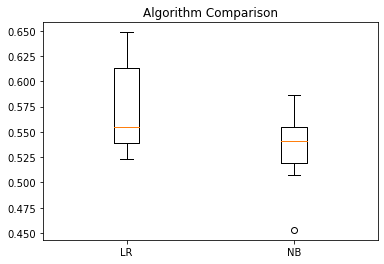

In [22]:
#Tried it with classification GP Vs. Linear regression Wine quality

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
dataset = read_csv(url, sep=';')

# shape
#print(dataset.shape)
#print(dataset.groupby('quality').size())

# Split-out validation dataset
array = dataset.values
X = array[:,0:11]
y = array[:,11]

#train 80% test 20% 
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('NB', GaussianNB()))
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    # Compare Algorithms
    
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

Text(0, 0.5, 'Predicted')

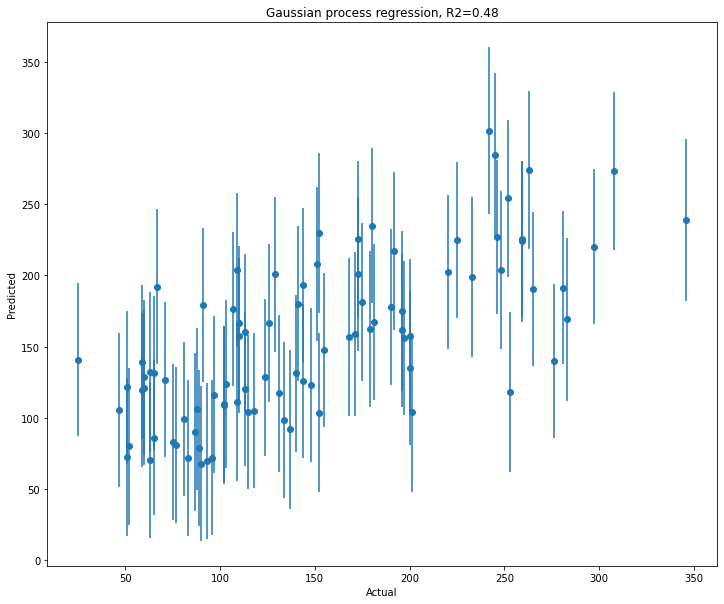

In [23]:
#Trying to train and graph different sklearn datasets/points with GPR 
#https://github.com/scikit-learn/scikit-learn/tree/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/datasets
from sklearn.datasets import load_boston
from sklearn.datasets import load_diabetes 
from sklearn.datasets import fetch_california_housing 
#Takes forever, has missing data that needs download, +20k samples, 
#don't currently have the hardware to want to run this agian

from sklearn.model_selection import train_test_split

#dataset 
#X, y = load_boston(return_X_y=True)
X, y = load_diabetes(return_X_y=True)
#X, y = fetch_california_housing(download_if_missing = False,return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

#Preset kernel given: https://towardsdatascience.com/getting-started-with-gaussian-process-regression-modeling-47e7982b534d
#Boston: kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10)  + WhiteKernel(5)
kernel = ConstantKernel(0.1) * RBF(25)  + WhiteKernel(25) #Diabetes
#Cali_Housing: kernel = RBF(25)

model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10, normalize_y= False)
model.fit(X_train, y_train)
y_pred_tr, y_pred_tr_std = model.predict(X_train, return_std=True)
y_pred_te, y_pred_te_std = model.predict(X_test, return_std=True)
#print(model.get_params())

#plot
plt.figure(figsize=(12,10))
plt.errorbar(y_test, y_pred_te, yerr=y_pred_te_std, fmt='o')
plt.title('Gaussian process regression, R2=%.2f' % r2_score(y_test, y_pred_te))
plt.xlabel('Actual')
plt.ylabel('Predicted')

### Conclusion 

The idea of using GP for multiple/infinite dimensional analysis through probability, marginalizing and conditioning the data with Bayesian inferences is an ingenious way to take really noisy data and training different types of functions for a variety of datasets. Whilst navigating the issue of missing data and need for cross validation. The downfalls come with datasets however have to be organized in certain ways (Or my inability to figure out how to set up the arrays just right?...) and the need for large datasets in order to purvey a higher score.
We may improve our scores by playing with more techniques of optimizing hyperparameters and automated model selection (in this project I settled for defaults or random adjustments trial/error), there are papers that go into depth for methods one may implement. A revision would see more methods to increase the model selection and refine focus on conditioning the program over multiple generations to establish an actually* heuristic program. 
Overall taking on this project allowed me to develop an understanding for both ML and different methods to use within sklearn, numpy, and generally form a better intuition on interaction with different forms of calculations. 

#### Possibly refrence (Different Kernels)  


E:\zthel\Documents\ANACONDA\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
E:\zthel\Documents\ANACONDA\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


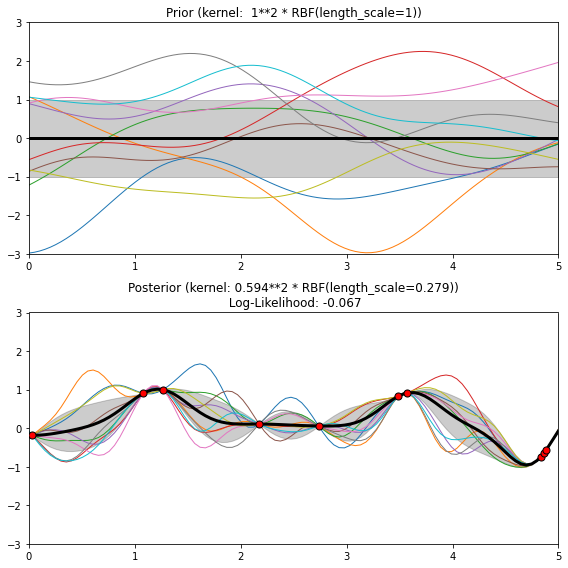

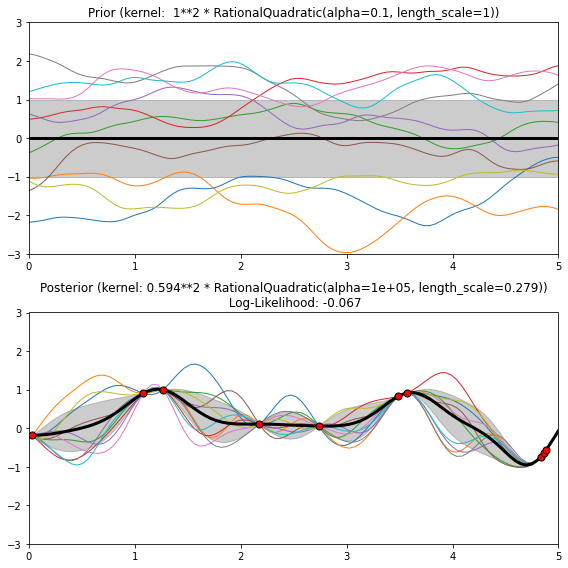

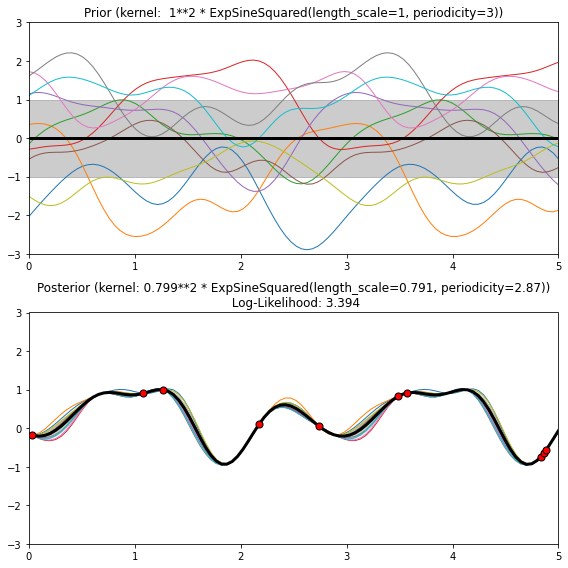

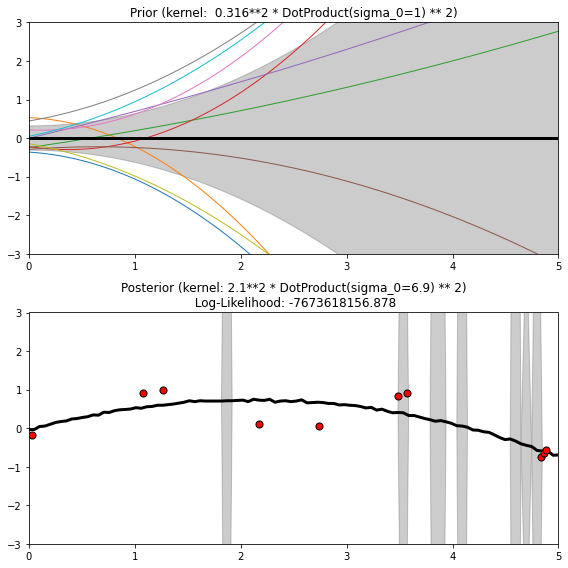

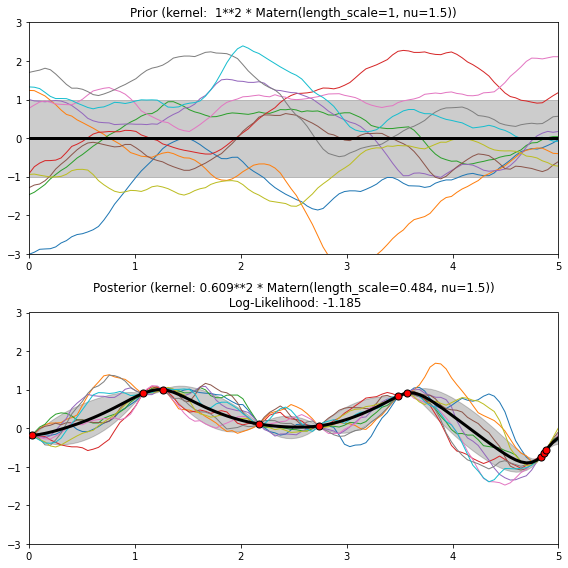

In [24]:
#Kernel comparisons
#https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor

#Different types of kernals avalible on Sklearn
from sklearn.gaussian_process.kernels import (RBF, 
                                              Matern, 
                                              RationalQuadratic,
                                              ExpSineSquared, 
                                              DotProduct,
                                              ConstantKernel)


kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

for kernel in kernels:
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()

### Other Citation/references

***Array Datasets:***

http://archive.ics.uci.edu/ml/datasets/Wine+Quality

#https://github.com/scikit-learn/scikit-learn/tree/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/datasets


***Neural network reading/videos: ***

https://morioh.com/p/6298668b9379

https://www.wandb.com/articles/fundamentals-of-neural-networks

https://sebastianraschka.com/faq/docs/softmax_regression.html * 

https://hackernoon.com/building-a-neural-network-only-using-numpy-7ba75da60ec0

https://machinelearningmastery.com/machine-learning-in-python-step-by-step/

***Weight*** https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78


**Gaussian Process:**
https://towardsdatascience.com/an-intuitive-guide-to-gaussian-processes-ec2f0b45c71d

https://gist.github.com/stober/4964727

https://peterroelants.github.io/posts/gaussian-process-tutorial/

https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes.ipynb?flush_cache=true